In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import xgboost as xgb
from catboost import CatBoostRegressor
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
import sys
print(sys.version)

3.11.2 (tags/v3.11.2:878ead1, Feb  7 2023, 16:38:35) [MSC v.1934 64 bit (AMD64)]


In [3]:
data = pd.read_csv('data.csv')
del data["Unnamed: 0"]
for col_name in data.columns:
    if col_name.startswith("Wskaźniki cen"):
        del data[col_name]
data

,month,growth,wig,wig_1m,wig_1y,wig20,wig20_1m,wig20_1y,usd,usd_1m,...,income_1y,expenses_1y,score_1y,unemployed,unemployed_year,unemployed_month,unemployment,unemployment_1m,unemployment_1y,inflation
0,2003-01,2.2,14501.390909,99.758368,92.895081,1182.224091,98.709599,84.840768,3.830805,97.883917,...,113.804474,91.232463,58.004940,3320.6,102.1,103.2,20.6,114.444444,113.812155,100.5
1,2003-02,2.2,13852.175000,95.523078,90.203868,1107.944000,93.716920,80.845211,3.866615,100.934802,...,105.984884,97.766662,85.140880,3344.2,102.0,100.7,20.7,100.485437,113.736264,100.5
2,2003-03,2.2,13818.895238,99.759751,91.043731,1101.812857,99.446620,81.021400,4.009524,103.695967,...,106.783628,102.336724,93.875329,3321.0,101.9,99.3,20.6,99.516908,113.186813,100.6
3,2003-04,3.8,14236.020000,103.018510,94.652201,1125.743500,102.171934,84.595694,3.963290,98.846912,...,107.151174,101.809143,90.172168,3246.1,101.3,97.7,20.3,98.543689,113.407821,100.3
4,2003-05,3.8,14842.295238,104.258741,96.847212,1157.359048,102.808415,86.214281,3.741419,94.401838,...,105.925522,104.450194,101.014162,3159.6,103.1,97.3,19.8,97.536946,114.450867,100.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-08,3.9,53965.914545,101.445456,78.326615,1662.664545,99.173530,72.561395,4.665650,99.550351,...,107.811226,114.759068,63.475161,806.9,84.0,99.6,5.2,100.000000,83.870968,116.1
236,2022-09,3.9,48962.650000,90.728843,69.092537,1483.501364,89.224334,63.348383,4.788236,102.627423,...,106.402357,113.819484,57.697763,801.7,85.8,99.3,5.1,98.076923,83.606557,117.2
237,2022-10,2.3,47364.929048,96.736858,64.493467,1427.012381,96.192185,59.111930,4.889443,102.113649,...,104.996851,112.698352,52.487372,796.0,87.4,99.3,5.1,100.000000,86.440678,117.9
238,2022-11,2.3,54522.466500,115.111471,76.647247,1691.497000,118.534150,73.247619,4.602995,94.141503,...,102.898320,111.267407,36.275833,800.2,89.0,100.5,5.1,100.000000,87.931034,117.5


In [4]:
target = list(data["inflation"])
target = target[1:]
target.append(None)
data["target"] = target
data

,month,growth,wig,wig_1m,wig_1y,wig20,wig20_1m,wig20_1y,usd,usd_1m,...,expenses_1y,score_1y,unemployed,unemployed_year,unemployed_month,unemployment,unemployment_1m,unemployment_1y,inflation,target
0,2003-01,2.2,14501.390909,99.758368,92.895081,1182.224091,98.709599,84.840768,3.830805,97.883917,...,91.232463,58.004940,3320.6,102.1,103.2,20.6,114.444444,113.812155,100.5,100.5
1,2003-02,2.2,13852.175000,95.523078,90.203868,1107.944000,93.716920,80.845211,3.866615,100.934802,...,97.766662,85.140880,3344.2,102.0,100.7,20.7,100.485437,113.736264,100.5,100.6
2,2003-03,2.2,13818.895238,99.759751,91.043731,1101.812857,99.446620,81.021400,4.009524,103.695967,...,102.336724,93.875329,3321.0,101.9,99.3,20.6,99.516908,113.186813,100.6,100.3
3,2003-04,3.8,14236.020000,103.018510,94.652201,1125.743500,102.171934,84.595694,3.963290,98.846912,...,101.809143,90.172168,3246.1,101.3,97.7,20.3,98.543689,113.407821,100.3,100.4
4,2003-05,3.8,14842.295238,104.258741,96.847212,1157.359048,102.808415,86.214281,3.741419,94.401838,...,104.450194,101.014162,3159.6,103.1,97.3,19.8,97.536946,114.450867,100.4,100.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-08,3.9,53965.914545,101.445456,78.326615,1662.664545,99.173530,72.561395,4.665650,99.550351,...,114.759068,63.475161,806.9,84.0,99.6,5.2,100.000000,83.870968,116.1,117.2
236,2022-09,3.9,48962.650000,90.728843,69.092537,1483.501364,89.224334,63.348383,4.788236,102.627423,...,113.819484,57.697763,801.7,85.8,99.3,5.1,98.076923,83.606557,117.2,117.9
237,2022-10,2.3,47364.929048,96.736858,64.493467,1427.012381,96.192185,59.111930,4.889443,102.113649,...,112.698352,52.487372,796.0,87.4,99.3,5.1,100.000000,86.440678,117.9,117.5
238,2022-11,2.3,54522.466500,115.111471,76.647247,1691.497000,118.534150,73.247619,4.602995,94.141503,...,111.267407,36.275833,800.2,89.0,100.5,5.1,100.000000,87.931034,117.5,116.6


In [5]:
for month_before in range(1,12):
    new_col = list(data["inflation"])
    new_col = new_col[:-month_before]
    for _ in range(month_before):
        new_col = [None, *new_col]
    data[f"inflation_{month_before}m"] = new_col
data[:20]

,month,growth,wig,wig_1m,wig_1y,wig20,wig20_1m,wig20_1y,usd,usd_1m,...,inflation_2m,inflation_3m,inflation_4m,inflation_5m,inflation_6m,inflation_7m,inflation_8m,inflation_9m,inflation_10m,inflation_11m
0,2003-01,2.2,14501.390909,99.758368,92.895081,1182.224091,98.709599,84.840768,3.830805,97.883917,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2003-02,2.2,13852.175000,95.523078,90.203868,1107.944000,93.716920,80.845211,3.866615,100.934802,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2003-03,2.2,13818.895238,99.759751,91.043731,1101.812857,99.446620,81.021400,4.009524,103.695967,...,100.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2003-04,3.8,14236.020000,103.018510,94.652201,1125.743500,102.171934,84.595694,3.963290,98.846912,...,100.5,100.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2003-05,3.8,14842.295238,104.258741,96.847212,1157.359048,102.808415,86.214281,3.741419,94.401838,...,100.6,100.5,100.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2003-06,3.8,15650.340000,105.444204,103.228985,1226.361000,105.962018,92.786428,3.799140,101.542756,...,100.3,100.6,100.5,100.5,NaN,NaN,NaN,NaN,NaN,NaN
6,2003-07,4.7,17200.273913,109.903516,127.465472,1337.491739,109.061829,117.238345,3.903587,102.749226,...,100.4,100.3,100.6,100.5,100.5,NaN,NaN,NaN,NaN,NaN
7,2003-08,4.7,19431.615000,112.972707,148.433189,1476.771000,110.413467,135.240511,3.918610,100.384852,...,100.8,100.4,100.3,100.6,100.5,100.5,NaN,NaN,NaN,NaN
8,2003-09,4.7,20351.063636,104.731715,155.631836,1561.299091,105.723846,145.312307,3.979191,101.545980,...,100.8,100.8,100.4,100.3,100.6,100.5,100.5,NaN,NaN,NaN
9,2003-10,4.7,20671.217391,101.573155,154.698401,1583.883913,101.446540,143.007107,3.923991,98.612793,...,100.7,100.8,100.8,100.4,100.3,100.6,100.5,100.5,NaN,NaN


In [6]:
data_1_timestep = data.copy()
data_1_timestep = data[["inflation","target"]]
data_1_timestep = data_1_timestep.dropna()

In [7]:
data_5_timestep = data.copy()
data_5_timestep = data[["inflation_4m","inflation_3m","inflation_2m","inflation_1m","inflation","target"]]
data_5_timestep = data_5_timestep.dropna()

In [8]:
data_12_timestep = data.copy()
data_12_timestep = data[["inflation_11m","inflation_10m","inflation_9m","inflation_8m","inflation_7m",
                        "inflation_6m","inflation_5m","inflation_4m","inflation_3m","inflation_2m",
                        "inflation_1m","inflation","target"]]
data_12_timestep = data_12_timestep.dropna()

In [9]:
data_1_timestep

,inflation,target
0,100.5,100.5
1,100.5,100.6
2,100.6,100.3
3,100.3,100.4
4,100.4,100.8
...,...,...
234,115.6,116.1
235,116.1,117.2
236,117.2,117.9
237,117.9,117.5


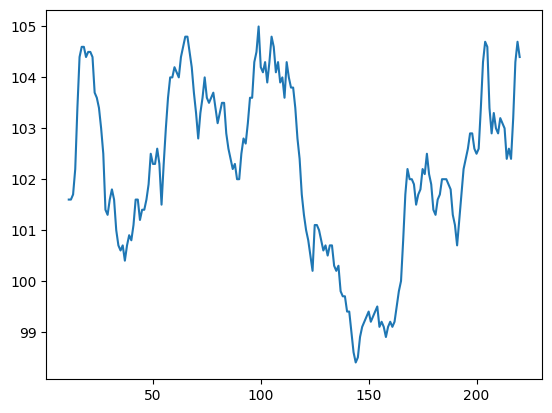

In [10]:
plt.plot(data_12_timestep["target"][:210])

In [11]:
data_12_timestep["target"][:210]

11     101.6
12     101.6
13     101.7
14     102.2
15     103.4
       ...  
216    102.4
217    103.2
218    104.3
219    104.7
220    104.4
Name: target, Length: 210, dtype: float64

In [12]:
data.iloc[180]

month                   2018-01
growth                      5.2
wig                    66107.28
wig_1m               105.107881
wig_1y               122.903338
wig20               2566.247619
wig20_1m             105.600059
wig20_1y             126.888003
usd                    3.414795
usd_1m                96.139111
usd_1y                83.000134
income                  35191.2
expenses                26629.0
score                    8562.2
income_1m             10.042729
expenses_1m            7.086544
score_1m             -33.770875
income_1y             95.220984
expenses_1y           88.153604
score_1y             126.849287
unemployed               1133.7
unemployed_year            81.1
unemployed_month          104.8
unemployment                6.8
unemployment_1m      103.030303
unemployment_1y            80.0
inflation                 101.9
target                    101.4
inflation_1m              102.1
inflation_2m              102.5
inflation_3m              102.1
inflatio

In [13]:
scaler = StandardScaler()
scaler.fit(data["inflation"].to_numpy().reshape(-1,1))

for df in [data_1_timestep, data_5_timestep, data_12_timestep]:
    for col_name in df.columns:
        df[col_name] = scaler.transform(df[col_name].to_numpy().reshape(-1,1))

In [14]:
def map_to_datasets(dataframe):
    split1 = 180
    split2 = 210
    x = dataframe.copy()
    del x["target"]
    return {"train": {"x": x[:split1], "y": dataframe[:split1]["target"]},
            "test" : {"x": x[split1:split2], "y": dataframe[split1:split2]["target"]},
            "test2": {"x": x[split2:], "y": dataframe[split2:]["target"]}
           }

datasets = list(map(map_to_datasets,[data_1_timestep, data_5_timestep, data_12_timestep]))
datasets

[{'train': {'x':      inflation
   0    -0.714687
   1    -0.714687
   2    -0.683826
   3    -0.776409
   4    -0.745548
   ..         ...
   175  -0.313495
   176  -0.190052
   177  -0.220913
   178  -0.097469
   179  -0.220913
   
   [180 rows x 1 columns],
   'y': 0     -0.714687
   1     -0.683826
   2     -0.776409
   3     -0.745548
   4     -0.622105
            ...   
   175   -0.190052
   176   -0.220913
   177   -0.097469
   178   -0.220913
   179   -0.282635
   Name: target, Length: 180, dtype: float64},
  'test': {'x':      inflation
   180  -0.282635
   181  -0.436939
   182  -0.467800
   183  -0.375217
   184  -0.344356
   185  -0.251774
   186  -0.251774
   187  -0.251774
   188  -0.282635
   189  -0.313495
   190  -0.467800
   191  -0.529522
   192  -0.652966
   193  -0.498661
   194  -0.344356
   195  -0.190052
   196  -0.128330
   197  -0.066608
   198   0.025975
   199   0.025975
   200  -0.066608
   201  -0.097469
   202  -0.066608
   203   0.180279
   204   0.4580

## Models using only inflation value

LSTM, only last month

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 32)          4352      
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 7,505
Trainable params: 7,505
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4
90/90 [==============================] - 4s 12ms/step - loss: 0.2516 - val_loss: 0.0590
Epoch 2/4
90/90 [==============================] - 0s 3ms/step - loss: 0.0767 - val_loss: 0.0266
Epoch 3/4
90/90 [==============================] - 0s 3ms/step - loss: 0.0194 - val_loss: 0.0164
Epoch 4/4
1/1 [===========

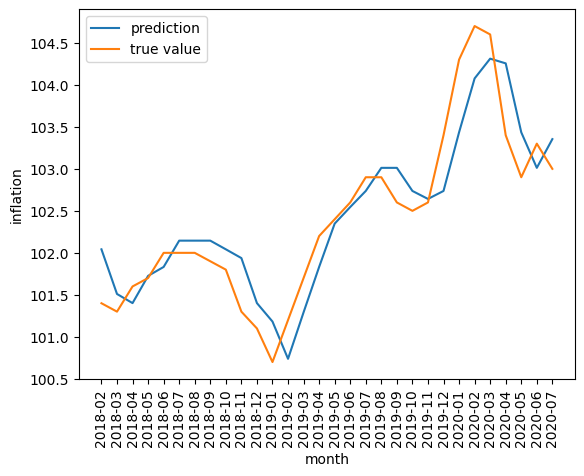

test mse: 0.01615651200188624
1/1 [==============================] - 0s 23ms/step


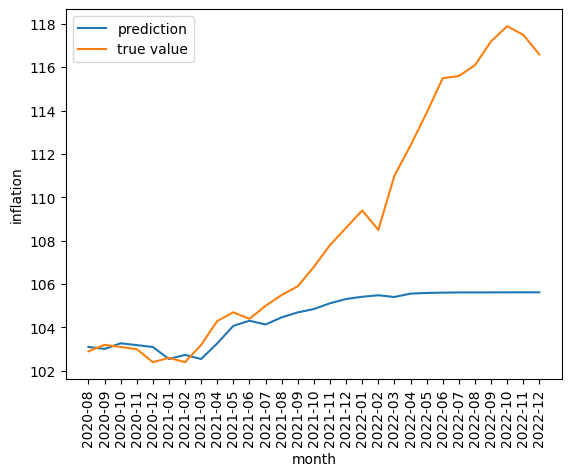

test2 mse: 3.4598397034523685


In [15]:
data_input = datasets[0]

model = Sequential()
model.add(LSTM(32, input_shape=(None, 1), return_sequences=True))
model.add(LSTM(16))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

model.fit(data_input["train"]["x"], data_input["train"]["y"], 
          epochs=4, 
          batch_size=2, 
          validation_data = (data_input["test"]["x"], data_input["test"]["y"]))

predictions = model.predict(data_input["test"]["x"])
plt.plot(scaler.inverse_transform(predictions).reshape(len(data_input["test"]["x"])),label="prediction")
plt.plot(scaler.inverse_transform(data_input["test"]["y"].to_numpy().reshape(-1,1)).reshape(len(data_input["test"]["x"])),label="true value")
plt.legend()
plt.xticks(ticks=range(len(data_input["test"]["x"])),labels=data["month"][181:211],rotation="vertical")
plt.ylabel("inflation")
plt.xlabel("month")
plt.show()
print("test mse:", mean_squared_error(data_input["test"]["y"], predictions))

predictions = model.predict(data_input["test2"]["x"])
plt.plot(scaler.inverse_transform(predictions).reshape(len(data_input["test2"]["x"])),label="prediction")
plt.plot(scaler.inverse_transform(data_input["test2"]["y"].to_numpy().reshape(-1,1)).reshape(len(data_input["test2"]["x"])),label="true value")
plt.legend()
plt.xticks(ticks=range(len(data_input["test2"]["x"])),labels=data["month"][211:],rotation="vertical")
plt.ylabel("inflation")
plt.xlabel("month")
plt.show()
print("test2 mse:", mean_squared_error(data_input["test2"]["y"], predictions))

LSTM, last 5 months

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 5, 32)             4352      
                                                                 
 lstm_3 (LSTM)               (None, 5, 64)             24832     
                                                                 
 lstm_4 (LSTM)               (None, 16)                5184      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 34,385
Trainable params: 34,385
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 1s 1s/step


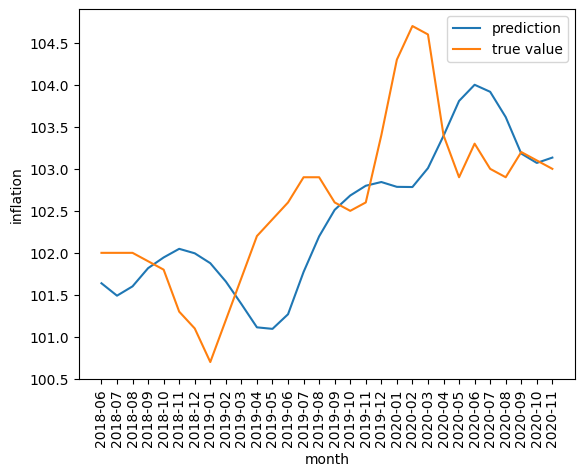

test mse: 0.06866833339316411
1/1 [==============================] - 0s 24ms/step


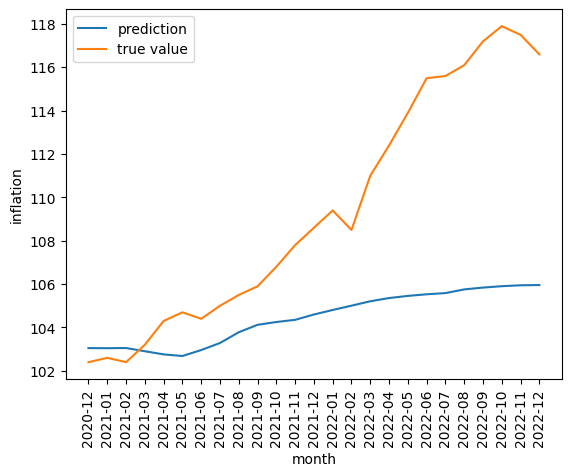

test2 mse: 4.065024217464045


In [16]:
data_input = datasets[1]

model = Sequential()
model.add(LSTM(32, input_shape=(5, 1), return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(16))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

model.fit(data_input["train"]["x"].to_numpy().reshape(data_input["train"]["x"].shape[0],data_input["train"]["x"].shape[1],1), data_input["train"]["y"], 
          epochs=1, 
          batch_size=2, 
          validation_data = (data_input["test"]["x"], data_input["test"]["y"]))

predictions = model.predict(data_input["test"]["x"])
plt.plot(scaler.inverse_transform(predictions).reshape(len(data_input["test"]["x"])),label="prediction")
plt.plot(scaler.inverse_transform(data_input["test"]["y"].to_numpy().reshape(-1,1)).reshape(len(data_input["test"]["x"])),label="true value")
plt.legend()
plt.xticks(ticks=range(len(data_input["test"]["x"])),labels=data["month"][185:215],rotation="vertical")
plt.ylabel("inflation")
plt.xlabel("month")
plt.show()
print("test mse:", mean_squared_error(data_input["test"]["y"], predictions))

predictions = model.predict(data_input["test2"]["x"])
plt.plot(scaler.inverse_transform(predictions).reshape(len(data_input["test2"]["x"])),label="prediction")
plt.plot(scaler.inverse_transform(data_input["test2"]["y"].to_numpy().reshape(-1,1)).reshape(len(data_input["test2"]["x"])),label="true value")
plt.legend()
plt.xticks(ticks=range(len(data_input["test2"]["x"])),labels=data["month"][215:],rotation="vertical")
plt.ylabel("inflation")
plt.xlabel("month")
plt.show()
print("test2 mse:", mean_squared_error(data_input["test2"]["y"], predictions))

LSTM, last 12 months

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 12, 32)            4352      
                                                                 
 lstm_6 (LSTM)               (None, 12, 64)            24832     
                                                                 
 lstm_7 (LSTM)               (None, 16)                5184      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 34,385
Trainable params: 34,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
90/90 [==============================] - 7s 22ms/step - loss: 0.1534 - val_loss: 0.0821
Epoch 2/20
90/90 [==============================] - 1s 9ms/step - loss: 0.1053 - va

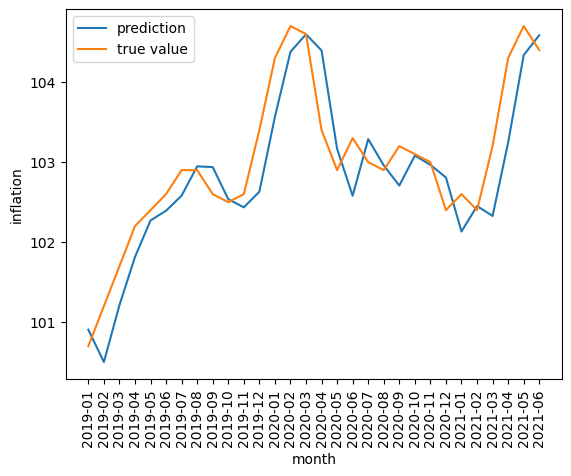

test mse: 0.021580551517850655
1/1 [==============================] - 0s 25ms/step


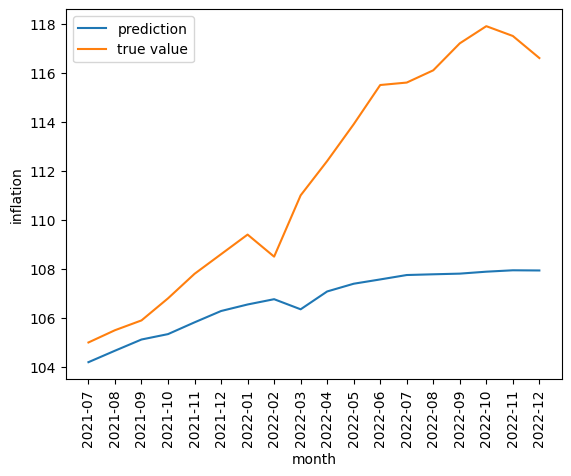

test2 mse: 3.519868806629955


In [17]:
data_input = datasets[2]

model = Sequential()
model.add(LSTM(32, input_shape=(12, 1), return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(16))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

model.fit(data_input["train"]["x"].to_numpy().reshape(data_input["train"]["x"].shape[0],data_input["train"]["x"].shape[1],1), data_input["train"]["y"], 
          epochs=20, 
          batch_size=2, 
          validation_data = (data_input["test"]["x"], data_input["test"]["y"]))

predictions = model.predict(data_input["test"]["x"])
plt.plot(scaler.inverse_transform(predictions).reshape(len(data_input["test"]["x"])),label="prediction")
plt.plot(scaler.inverse_transform(data_input["test"]["y"].to_numpy().reshape(-1,1)).reshape(len(data_input["test"]["x"])),label="true value")
plt.legend()
plt.xticks(ticks=range(len(data_input["test"]["x"])),labels=data["month"][192:222],rotation="vertical")
plt.ylabel("inflation")
plt.xlabel("month")
plt.show()
print("test mse:", mean_squared_error(data_input["test"]["y"], predictions))

predictions = model.predict(data_input["test2"]["x"])
plt.plot(scaler.inverse_transform(predictions).reshape(len(data_input["test2"]["x"])),label="prediction")
plt.plot(scaler.inverse_transform(data_input["test2"]["y"].to_numpy().reshape(-1,1)).reshape(len(data_input["test2"]["x"])),label="true value")
plt.legend()
plt.xticks(ticks=range(len(data_input["test2"]["x"])),labels=data["month"][222:],rotation="vertical")
plt.ylabel("inflation")
plt.xlabel("month")
plt.show()
print("test2 mse:", mean_squared_error(data_input["test2"]["y"], predictions))

KNN, last 12 months

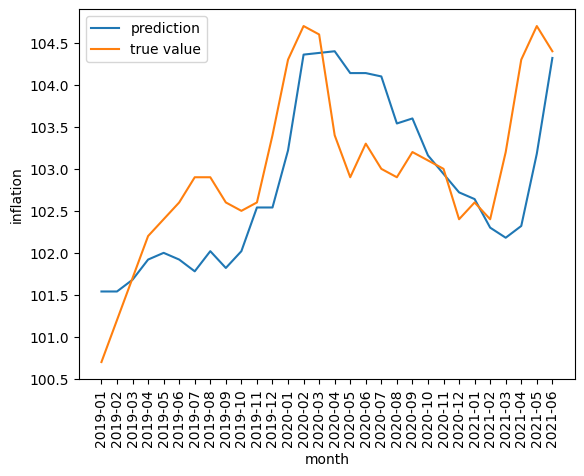

test mse: 0.05995397148856666


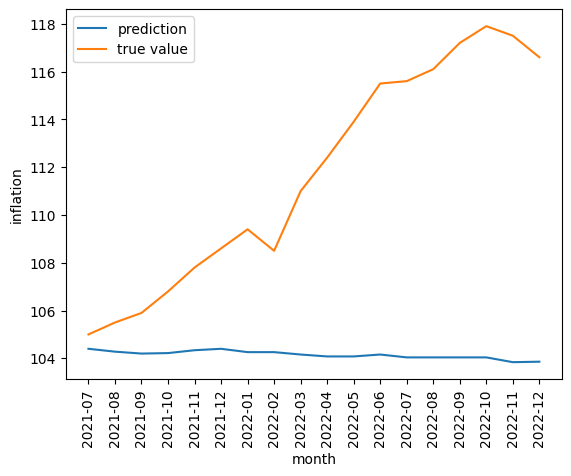

test2 mse: 7.5117874564005955


In [18]:
data_input = datasets[2]

knn = KNeighborsRegressor(n_neighbors=5, metric="euclidean")
knn.fit(data_input["train"]["x"],data_input["train"]["y"])

predictions = knn.predict(data_input["test"]["x"])
plt.plot(scaler.inverse_transform(predictions.reshape(1,-1)).reshape(len(data_input["test"]["x"])),label="prediction")
plt.plot(scaler.inverse_transform(data_input["test"]["y"].to_numpy().reshape(-1,1)).reshape(len(data_input["test"]["x"])),label="true value")
plt.legend()
plt.xticks(ticks=range(len(data_input["test"]["x"])),labels=data["month"][192:222],rotation="vertical")
plt.ylabel("inflation")
plt.xlabel("month")
plt.show()
print("test mse:", mean_squared_error(data_input["test"]["y"], predictions))

predictions = knn.predict(data_input["test2"]["x"])
plt.plot(scaler.inverse_transform(predictions.reshape(1,-1)).reshape(len(data_input["test2"]["x"])),label="prediction")
plt.plot(scaler.inverse_transform(data_input["test2"]["y"].to_numpy().reshape(-1,1)).reshape(len(data_input["test2"]["x"])),label="true value")
plt.legend()
plt.xticks(ticks=range(len(data_input["test2"]["x"])),labels=data["month"][222:],rotation="vertical")
plt.ylabel("inflation")
plt.xlabel("month")
plt.show()
print("test2 mse:", mean_squared_error(data_input["test2"]["y"], predictions))

CatBoost, last 12 months

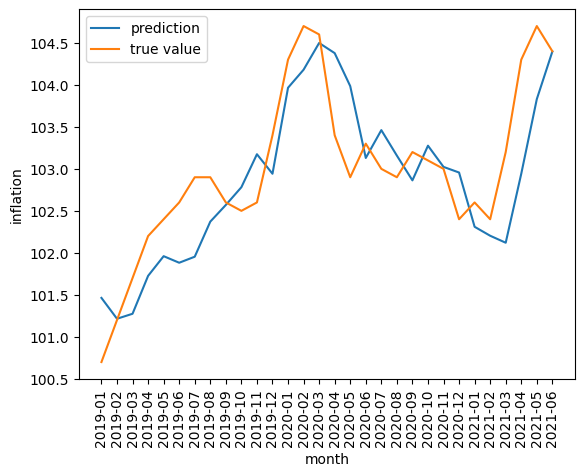

test mse: 0.033868590423099566


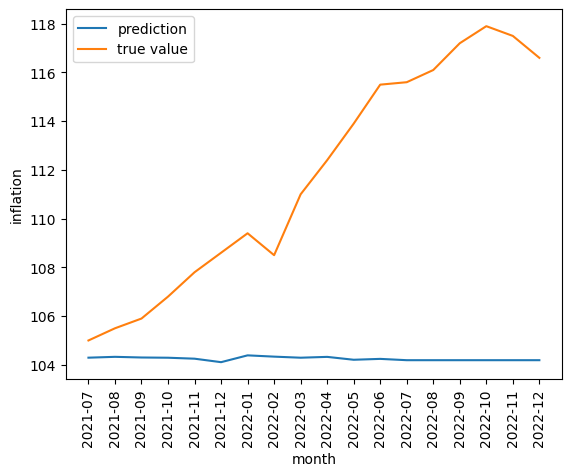

test2 mse: 7.28624657375153


In [19]:
data_input = datasets[2]

model = CatBoostRegressor(depth=6, n_estimators=100)
model.fit(data_input["train"]["x"],data_input["train"]["y"],silent=True)

predictions = model.predict(data_input["test"]["x"])
plt.plot(scaler.inverse_transform(predictions.reshape(1,-1)).reshape(len(data_input["test"]["x"])),label="prediction")
plt.plot(scaler.inverse_transform(data_input["test"]["y"].to_numpy().reshape(-1,1)).reshape(len(data_input["test"]["x"])),label="true value")
plt.legend()
plt.xticks(ticks=range(len(data_input["test"]["x"])),labels=data["month"][192:222],rotation="vertical")
plt.ylabel("inflation")
plt.xlabel("month")
plt.show()
print("test mse:", mean_squared_error(data_input["test"]["y"], predictions))

predictions = model.predict(data_input["test2"]["x"])
plt.plot(scaler.inverse_transform(predictions.reshape(1,-1)).reshape(len(data_input["test2"]["x"])),label="prediction")
plt.plot(scaler.inverse_transform(data_input["test2"]["y"].to_numpy().reshape(-1,1)).reshape(len(data_input["test2"]["x"])),label="true value")
plt.legend()
plt.xticks(ticks=range(len(data_input["test2"]["x"])),labels=data["month"][222:],rotation="vertical")
plt.ylabel("inflation")
plt.xlabel("month")
plt.show()
print("test2 mse:", mean_squared_error(data_input["test2"]["y"], predictions))

XGBRegressor last 12 months

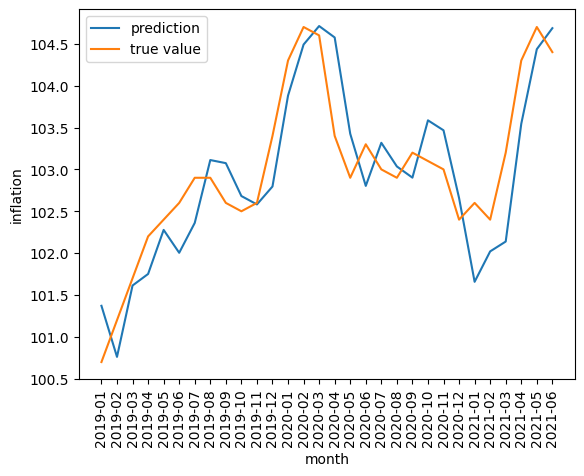

test mse: 0.025163041713284363


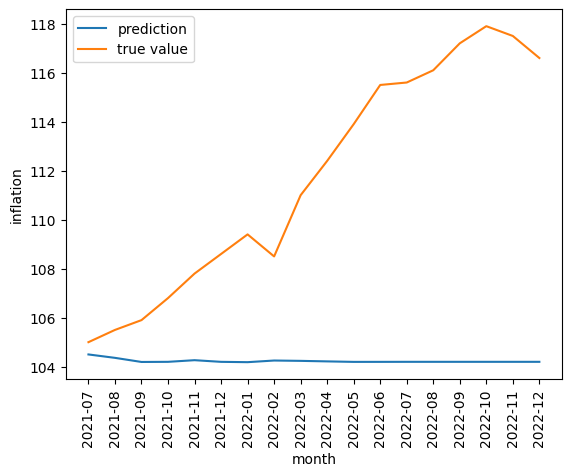

test2 mse: 7.314097310857733


In [20]:
data_input = datasets[2]

model = xgb.XGBRegressor(n_estimators=500,max_depth=5)
model.fit(data_input["train"]["x"],data_input["train"]["y"])

predictions = model.predict(data_input["test"]["x"])
plt.plot(scaler.inverse_transform(predictions.reshape(1,-1)).reshape(len(data_input["test"]["x"])),label="prediction")
plt.plot(scaler.inverse_transform(data_input["test"]["y"].to_numpy().reshape(-1,1)).reshape(len(data_input["test"]["x"])),label="true value")
plt.legend()
plt.xticks(ticks=range(len(data_input["test"]["x"])),labels=data["month"][192:222],rotation="vertical")
plt.ylabel("inflation")
plt.xlabel("month")
plt.show()
print("test mse:", mean_squared_error(data_input["test"]["y"], predictions))

predictions = model.predict(data_input["test2"]["x"])
plt.plot(scaler.inverse_transform(predictions.reshape(1,-1)).reshape(len(data_input["test2"]["x"])),label="prediction")
plt.plot(scaler.inverse_transform(data_input["test2"]["y"].to_numpy().reshape(-1,1)).reshape(len(data_input["test2"]["x"])),label="true value")
plt.legend()
plt.xticks(ticks=range(len(data_input["test2"]["x"])),labels=data["month"][222:],rotation="vertical")
plt.ylabel("inflation")
plt.xlabel("month")
plt.show()
print("test2 mse:", mean_squared_error(data_input["test2"]["y"], predictions))

Random Forest, last 12 months

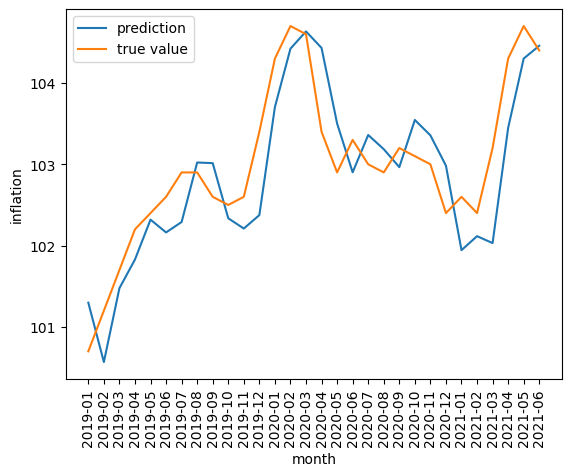

test mse: 0.02745843766425109


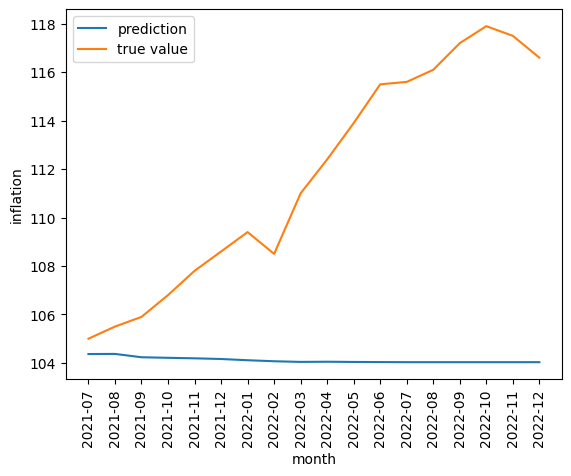

test2 mse: 7.529080493941738


In [21]:
data_input = datasets[2]

model = RandomForestRegressor()
model.fit(data_input["train"]["x"],data_input["train"]["y"])

predictions = model.predict(data_input["test"]["x"])
plt.plot(scaler.inverse_transform(predictions.reshape(1,-1)).reshape(len(data_input["test"]["x"])),label="prediction")
plt.plot(scaler.inverse_transform(data_input["test"]["y"].to_numpy().reshape(-1,1)).reshape(len(data_input["test"]["x"])),label="true value")
plt.legend()
plt.xticks(ticks=range(len(data_input["test"]["x"])),labels=data["month"][192:222],rotation="vertical")
plt.ylabel("inflation")
plt.xlabel("month")
plt.show()
print("test mse:", mean_squared_error(data_input["test"]["y"], predictions))

predictions = model.predict(data_input["test2"]["x"])
plt.plot(scaler.inverse_transform(predictions.reshape(1,-1)).reshape(len(data_input["test2"]["x"])),label="prediction")
plt.plot(scaler.inverse_transform(data_input["test2"]["y"].to_numpy().reshape(-1,1)).reshape(len(data_input["test2"]["x"])),label="true value")
plt.legend()
plt.xticks(ticks=range(len(data_input["test2"]["x"])),labels=data["month"][222:],rotation="vertical")
plt.ylabel("inflation")
plt.xlabel("month")
plt.show()
print("test2 mse:", mean_squared_error(data_input["test2"]["y"], predictions))

In [22]:
for col_name in data.columns:
    if col_name.startswith("inflation_"):
        del data[col_name]
        
data.columns

Index(['month', 'growth', 'wig', 'wig_1m', 'wig_1y', 'wig20', 'wig20_1m',
       'wig20_1y', 'usd', 'usd_1m', 'usd_1y', 'income', 'expenses', 'score',
       'income_1m', 'expenses_1m', 'score_1m', 'income_1y', 'expenses_1y',
       'score_1y', 'unemployed', 'unemployed_year', 'unemployed_month',
       'unemployment', 'unemployment_1m', 'unemployment_1y', 'inflation',
       'target'],
      dtype='object')

In [23]:
train_test_data = data[:222]
train_data = train_test_data[:192]
test_data = train_test_data[192:]
test_data_2 = data[222:]
test_data_2 = test_data_2.dropna()

## Multiple features prediction

Using only 2 features provided best results

In [24]:
features_count = 2

x_train = train_data.copy()
del x_train["target"]
del x_train["month"]
y_train =train_data["target"]

kbest = SelectKBest(f_regression, k=features_count)
x_train = kbest.fit_transform(x_train, y_train)
features = kbest.get_feature_names_out()

x_test = test_data.copy()
for col_name in x_test.columns:
    if not col_name in features:
        del x_test[col_name]
y_test = test_data["target"]

x_test_2 = test_data_2.copy()
for col_name in test_data_2.columns:
    if not col_name in features:
        del x_test_2[col_name]
y_test_2 = test_data_2["target"]

scaler_x = StandardScaler()
scaler_y = StandardScaler()
x_train = scaler_x.fit_transform(x_train)
y_train = scaler_y.fit_transform(y_train.to_numpy().reshape(-1,1))
x_test = scaler_x.transform(x_test)
y_test = scaler_y.transform(y_test.to_numpy().reshape(-1,1))
x_test_2 = scaler_x.transform(x_test_2)
y_test_2 = scaler_y.transform(y_test_2.to_numpy().reshape(-1,1))

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [25]:
features

array(['usd', 'inflation'], dtype=object)

usd - usredniony kurs zakupu dolara za pomoca PLN z jednego miesiaca

inflation - inflacja w aktualnym miesiacu w stosunku do analogicznego miesiaca poprzedniego roku

train 0.035316006636284585
test 0.10052746554372496
test2 26.594823504710714


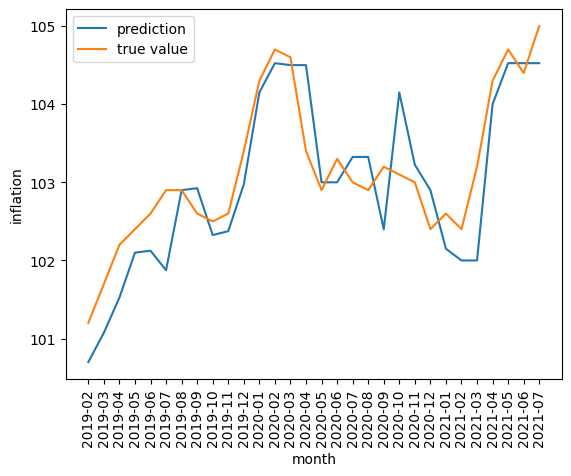

test mse: 0.10052746554372496


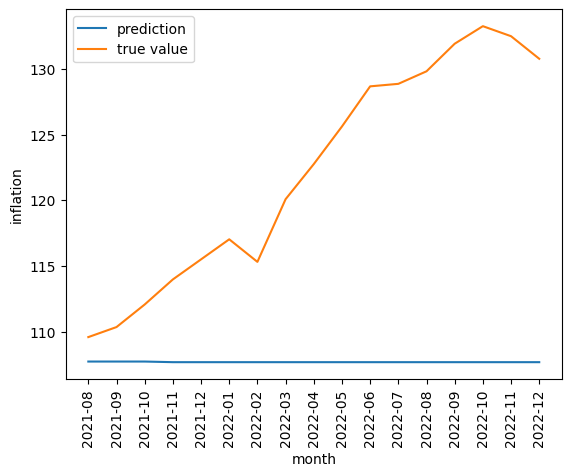

test2 mse: 26.594823504710714


In [26]:
knn = KNeighborsRegressor(n_neighbors=4, metric="manhattan")
knn.fit(x_train,y_train)
print("train",mean_squared_error(knn.predict(x_train),y_train))
print("test",mean_squared_error(knn.predict(x_test),y_test))
print("test2",mean_squared_error(knn.predict(x_test_2),y_test_2))

predictions = knn.predict(x_test)
plt.plot(scaler_y.inverse_transform(predictions.reshape(1,-1)).reshape(len(x_test)),label="prediction")
plt.plot(scaler_y.inverse_transform(y_test.reshape(-1,1)).reshape(len(x_test)),label="true value")
plt.legend()
plt.xticks(ticks=range(len(x_test)),labels=data["month"][193:223],rotation="vertical")
plt.ylabel("inflation")
plt.xlabel("month")
plt.show()
print("test mse:", mean_squared_error(y_test, predictions))

predictions = knn.predict(x_test_2)
plt.plot(scaler.inverse_transform(predictions.reshape(1,-1)).reshape(len(x_test_2)),label="prediction")
plt.plot(scaler.inverse_transform(y_test_2.reshape(-1,1)).reshape(len(x_test_2)),label="true value")
plt.legend()
plt.xticks(ticks=range(len(x_test_2)),labels=data["month"][223:],rotation="vertical")
plt.ylabel("inflation")
plt.xlabel("month")
plt.show()
print("test2 mse:", mean_squared_error(y_test_2, predictions))

C:\Users\Admin\AppData\Local\Temp\ipykernel_15552\3321106547.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train,y_train)


train 0.03917423415967502
test 0.10563123588500284
test2 27.33428820310159


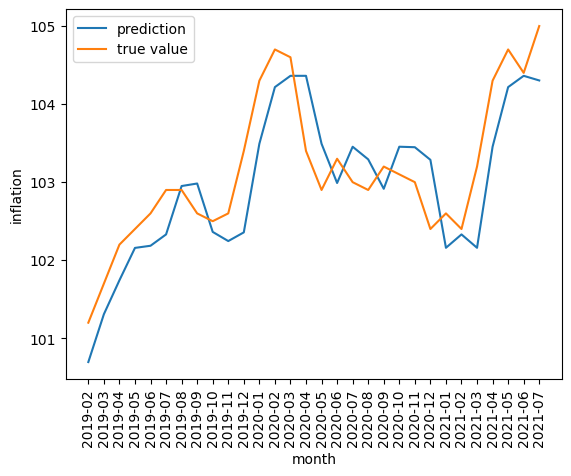

test mse: 0.10563123588500284


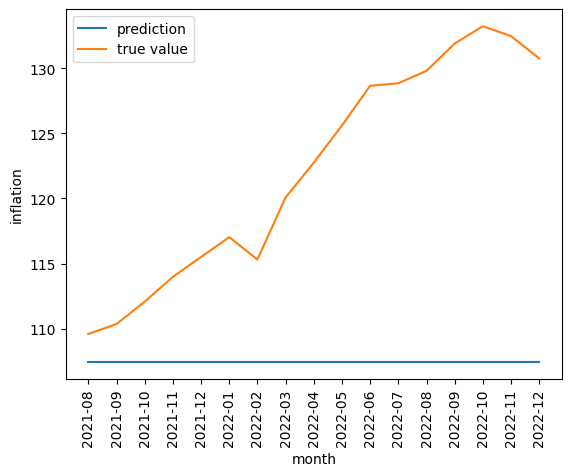

test2 mse: 27.33428820310159


In [27]:
model = RandomForestRegressor(min_samples_split=5, max_depth=3)
model.fit(x_train,y_train)
print("train",mean_squared_error(model.predict(x_train),y_train))
print("test",mean_squared_error(model.predict(x_test),y_test))
print("test2",mean_squared_error(model.predict(x_test_2),y_test_2))

predictions = model.predict(x_test)
plt.plot(scaler_y.inverse_transform(predictions.reshape(1,-1)).reshape(len(x_test)),label="prediction")
plt.plot(scaler_y.inverse_transform(y_test.reshape(-1,1)).reshape(len(x_test)),label="true value")
plt.legend()
plt.xticks(ticks=range(len(x_test)),labels=data["month"][193:223],rotation="vertical")
plt.ylabel("inflation")
plt.xlabel("month")
plt.show()
print("test mse:", mean_squared_error(y_test, predictions))

predictions = model.predict(x_test_2)
plt.plot(scaler.inverse_transform(predictions.reshape(1,-1)).reshape(len(x_test_2)),label="prediction")
plt.plot(scaler.inverse_transform(y_test_2.reshape(-1,1)).reshape(len(x_test_2)),label="true value")
plt.legend()
plt.xticks(ticks=range(len(x_test_2)),labels=data["month"][223:],rotation="vertical")
plt.ylabel("inflation")
plt.xlabel("month")
plt.show()
print("test2 mse:", mean_squared_error(y_test_2, predictions))

train 5.84273141452584e-06
test 0.13238317674995415
test2 27.26952756704818


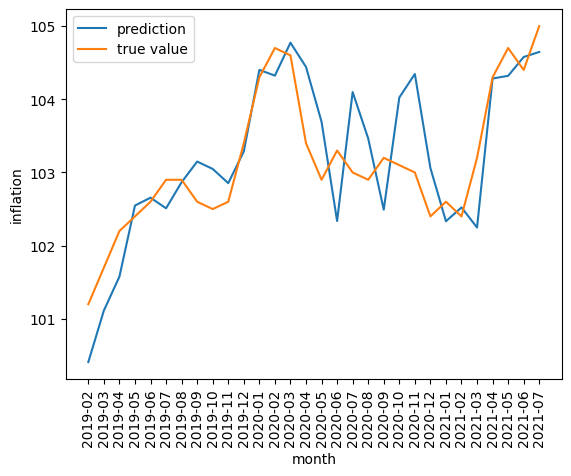

test mse: 0.13238317674995415


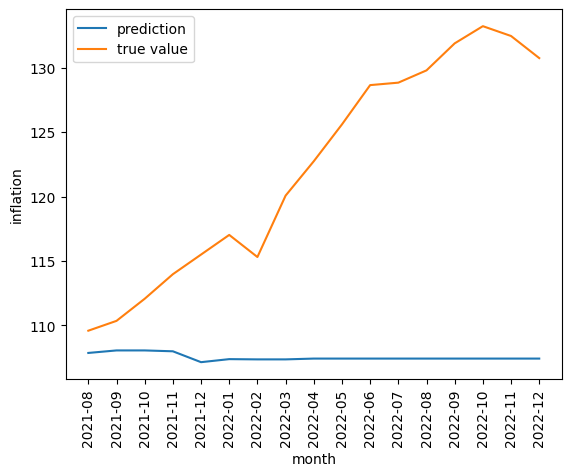

test2 mse: 27.26952756704818


In [28]:
model = xgb.XGBRegressor(n_estimators=500,max_depth=5)
model.fit(x_train,y_train)
print("train",mean_squared_error(model.predict(x_train),y_train))
print("test",mean_squared_error(model.predict(x_test),y_test))
print("test2",mean_squared_error(model.predict(x_test_2),y_test_2))

predictions = model.predict(x_test)
plt.plot(scaler_y.inverse_transform(predictions.reshape(1,-1)).reshape(len(x_test)),label="prediction")
plt.plot(scaler_y.inverse_transform(y_test.reshape(-1,1)).reshape(len(x_test)),label="true value")
plt.legend()
plt.xticks(ticks=range(len(x_test)),labels=data["month"][193:223],rotation="vertical")
plt.ylabel("inflation")
plt.xlabel("month")
plt.show()
print("test mse:", mean_squared_error(y_test, predictions))

predictions = model.predict(x_test_2)
plt.plot(scaler.inverse_transform(predictions.reshape(1,-1)).reshape(len(x_test_2)),label="prediction")
plt.plot(scaler.inverse_transform(y_test_2.reshape(-1,1)).reshape(len(x_test_2)),label="true value")
plt.legend()
plt.xticks(ticks=range(len(x_test_2)),labels=data["month"][223:],rotation="vertical")
plt.ylabel("inflation")
plt.xlabel("month")
plt.show()
print("test2 mse:", mean_squared_error(y_test_2, predictions))

train 0.006736739954382444
test 0.0956160557977087
test2 29.33826782521257


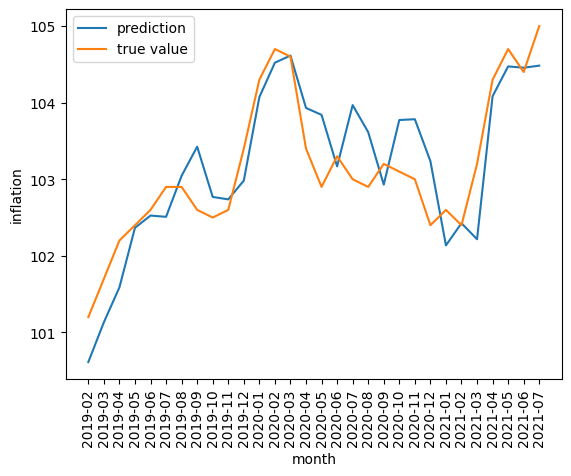

test mse: 0.0956160557977087


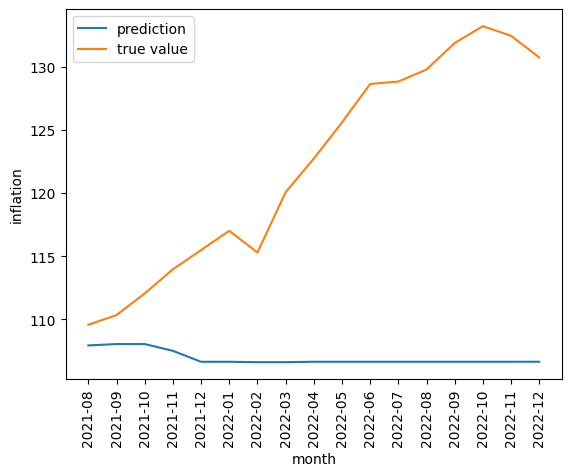

test2 mse: 29.33826782521257


In [29]:
model = CatBoostRegressor(depth=6, n_estimators=1000)
model.fit(x_train,y_train,silent=True)
print("train",mean_squared_error(model.predict(x_train),y_train))
print("test",mean_squared_error(model.predict(x_test),y_test))
print("test2",mean_squared_error(model.predict(x_test_2),y_test_2))

predictions = model.predict(x_test)
plt.plot(scaler_y.inverse_transform(predictions.reshape(1,-1)).reshape(len(x_test)),label="prediction")
plt.plot(scaler_y.inverse_transform(y_test.reshape(-1,1)).reshape(len(x_test)),label="true value")
plt.legend()
plt.xticks(ticks=range(len(x_test)),labels=data["month"][193:223],rotation="vertical")
plt.ylabel("inflation")
plt.xlabel("month")
plt.show()
print("test mse:", mean_squared_error(y_test, predictions))

predictions = model.predict(x_test_2)
plt.plot(scaler.inverse_transform(predictions.reshape(1,-1)).reshape(len(x_test_2)),label="prediction")
plt.plot(scaler.inverse_transform(y_test_2.reshape(-1,1)).reshape(len(x_test_2)),label="true value")
plt.legend()
plt.xticks(ticks=range(len(x_test_2)),labels=data["month"][223:],rotation="vertical")
plt.ylabel("inflation")
plt.xlabel("month")
plt.show()
print("test2 mse:", mean_squared_error(y_test_2, predictions))